# Classifier-free Diffusion Guidance

As you have seen in [previous example](./06-classifier-guidance.ipynb), the classifier guided diffusion requires an extra classifier, and building classifier is so hard because it needs training on Gaussian noised samples.<br>
Furthermore, it makes it difficult to predict with a classifier, when conditioning on information, such as a generic text sequence (text prompt).

Classifier-free guidance is proposed to build a diffusion model which can generate "low temperature" samples like classifier guidance, but without a classifier.

- Same like classifier guidance, you can steer a trade-off between fidelity and diversity, such like "temperature" in regular LLMs.
- Classifier-free guidance, however, does not require an extra classifier model with noised images.
- The architecture of classifier-free guided models can be stably leveraged into models conditioned on a text sequence (or other modalities), because it doesn't need a classifier. (See below note.)

*(back to [index](https://github.com/tsmatz/diffusion-tutorials/))*

## Architecture & Method

Now we start with the following equation in classifier guided diffusion (see (6) in [classifier guidance tutorial](./06-classifier-guidance.ipynb)), and try to rewrite this equation not to use the classifier $p(y|\mathbf{x}_t)$.

$\displaystyle \tilde{\epsilon}_{\theta}(\mathbf{x}_t, y) = \epsilon_{\theta}(\mathbf{x}_t, y) - s \sigma_t \nabla_{\mathbf{x}_t} \log p(y|\mathbf{x}_t) \;\;\;\;\;\; (1)$

By Bayesian rule, the classifier $p(y|\mathbf{x}_t)$ has the following property. :

$\displaystyle p(y|\mathbf{x}_t) \propto \frac{p(\mathbf{x}_t|y)}{p(\mathbf{x}_t)} $

Hence,

$\displaystyle \nabla_{\mathbf{x}_t} \log p(y|\mathbf{x}_t) = \nabla_{\mathbf{x}_t} \log p(\mathbf{x}_t|y) - \nabla_{\mathbf{x}_t} \log p(\mathbf{x}_t) \;\;\;\;\;\; (2)$

By substituting (2) into the equation (1), we then get :

$\displaystyle \tilde{\epsilon}_{\theta}(\mathbf{x}_t, y) = \epsilon_{\theta}(\mathbf{x}_t, y) - s \sigma_t \left( \nabla_{\mathbf{x}_t} \log p(\mathbf{x}_t|y) - \nabla_{\mathbf{x}_t} \log p(\mathbf{x}_t) \right)$

As we saw in classifier guided diffusion, $\epsilon_{\theta}(\mathbf{x}_t) = -\sigma_t \nabla_{\mathbf{x}_t} \log p(\mathbf{x}_t)$.<br>
The above equation is then written as :

$\displaystyle \tilde{\epsilon}_{\theta}(\mathbf{x}_t, y) = (1 + s) \epsilon_{\theta}(\mathbf{x}_t, y) - s \epsilon_{\theta}(\mathbf{x}_t) \;\;\;\;\;\; (3)$

> Note : As you can see above, it becomes a traditional conditional diffusion model discussed in [this tutorial](05-class-conditional.ipynb) when $s=0$.<br>
> When you set $s^{\prime} = -s$, then $\tilde{\epsilon}_{\theta}(\mathbf{x}_t, y) = (1 - s^{\prime}) \epsilon_{\theta}(\mathbf{x}_t, y) + s^{\prime} \epsilon_{\theta}(\mathbf{x}_t)$. Thus $s^{\prime}$ works like a normalizer, but always it's negative.

This equation (3) has no classifier.<br>
Instead of using extra classifier seen in classifier guidance, this method jointly trains 2 score functions - a conditional diffusion model $\epsilon_{\theta}(\mathbf{x}_t, y)$ and an unconditional diffusion model $\epsilon_{\theta}(\mathbf{x}_t)$.

> Note : You may be able to train $\epsilon_{\theta}(\mathbf{x}_t, y)$ separately from $\epsilon_{\theta}(\mathbf{x}_t)$, but this makes the training difficult. The models are, therefore, jointly trained in the paper. (Here we then also build both models jointly.)<br>
> For more details, see the original paper [[Ho & Salimans, 2022](https://arxiv.org/pdf/2207.12598)].

## Note: Classifier-free guidance with a text prompt (Text-to-image)

In this example, we'll build a simple classifier-free guided model with a class label for your learning purpose.<br>
But, you can leverage this architecture into guided models conditioned on a generic text prompt, by using text encoder - such as, [Transformer encoder](https://github.com/tsmatz/nlp-tutorials/blob/master/09_transformer.ipynb), etc.

For example, in [[Nichol, et. al., 2022](https://arxiv.org/pdf/2112.10741)] (the paper of GLIDE), they compare a classifier guided diffusion (CLIP guidance discussed in [classifier guidance tutorial](./06-classifier-guidance.ipynb)) with classifier-free guided diffusion (in which Transformer-based encoder is used) by a text prompt, and they find that classifier-free guidance has favorable results in many aspects.

Today classifier-free guidance architecture is widely used in a lot of famous diffusion models - such as, GLIDE, Imagen, and Stable Diffusion.<br>
A core difference between GLIDE and Imagen is a choice of text encoder, in which Imagen uses a frozen (pre-trained) large language model as text encoder.<br>
Stable diffusion (till version 2) also uses an existing frozen (pre-trained) text encoder in CLIP. Stable diffusion version 3 and above jointly mixes CLIP encoder with text-focused encoder (T5) to improve text understanding in details - e.g., understanding a high degree of detail or longer spelled text. (Also see [[Balaji et. al, 2023](https://arxiv.org/pdf/2211.01324)] from NVIDIA.)

## Build and Train model

Now let's see the code (implementation).

Before we start, we need to install the required packages. Please follow instructions in [README.md](../README.md) to create the conda environment.

### 1. Load data

We load images in CIFAR-100 dataset and create the dataloader.<br>
Each batch has shape ```[batch_size, 3, 32 32]```.

In [1]:
import torch
from torchvision import datasets, transforms

batch_size = 128

dataset = datasets.CIFAR100(
    "./data",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]))
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

Now I show 100 examples.

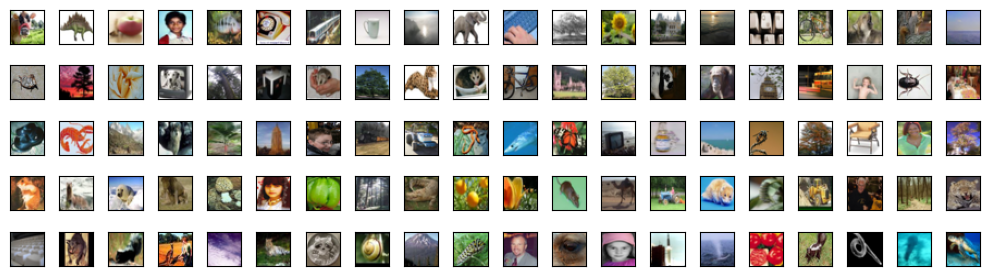

In [2]:
import numpy as np
import matplotlib.pyplot as plt

"""
for _, (data, _) in enumerate(loader):
    images = data[:3]
    break
for i in images:
    channel_last = np.transpose(i.numpy(), (1, 2, 0)) # (C, H, W) --> (H, W, C)
    plt.figure(figsize = (0.4,0.4))
    plt.imshow(channel_last)
    plt.show()
"""
num_row = 5
num_col = 20
fig, axes = plt.subplots(num_row, num_col, figsize=(10,3))
tmp_loader = torch.utils.data.DataLoader(dataset, batch_size=num_row*num_col, shuffle=False)
for data, label in tmp_loader:
    for i in range(num_row*num_col):
        image = data[i].numpy()
        channel_last = np.transpose(image, (1, 2, 0)) # (C, H, W) --> (H, W, C)
        row = i//num_col
        col = i%num_col
        ax = axes[row, col]
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(channel_last)
    break
plt.tight_layout()
plt.show()
del tmp_loader

In this dataset, there exist 100 classes as follows.

In [3]:
num_classes = 100
classes = [
    "apple",
    "aquarium_fish",
    "baby",
    "bear",
    "beaver",
    "bed",
    "bee",
    "beetle",
    "bicycle",
    "bottle",
    "bowl",
    "boy",
    "bridge",
    "bus",
    "butterfly",
    "camel",
    "can",
    "castle",
    "caterpillar",
    "cattle",
    "chair",
    "chimpanzee",
    "clock",
    "cloud",
    "cockroach",
    "couch",
    "crab",
    "crocodile",
    "cup",
    "dinosaur",
    "dolphin",
    "elephant",
    "flatfish",
    "forest",
    "fox",
    "girl",
    "hamster",
    "house",
    "kangaroo",
    "keyboard",
    "lamp",
    "lawn_mower",
    "leopard",
    "lion",
    "lizard",
    "lobster",
    "man",
    "maple_tree",
    "motorcycle",
    "mountain",
    "mouse",
    "mushroom",
    "oak_tree",
    "orange",
    "orchid",
    "otter",
    "palm_tree",
    "pear",
    "pickup_truck",
    "pine_tree",
    "plain",
    "plate",
    "poppy",
    "porcupine",
    "possum",
    "rabbit",
    "raccoon",
    "ray",
    "road",
    "rocket",
    "rose",
    "sea",
    "seal",
    "shark",
    "shrew",
    "skunk",
    "skyscraper",
    "snail",
    "snake",
    "spider",
    "squirrel",
    "streetcar",
    "sunflower",
    "sweet_pepper",
    "table",
    "tank",
    "telephone",
    "television",
    "tiger",
    "tractor",
    "train",
    "trout",
    "tulip",
    "turtle",
    "wardrobe",
    "whale",
    "willow_tree",
    "wolf",
    "woman",
    "worm"
]

### 2. Build class conditional U-Net $\epsilon_{\theta}(\mathbf{x}, y)$

In the original paper [[Ho & Salimans, 2022](https://arxiv.org/pdf/2207.12598)], the model architecture is from [here](https://arxiv.org/pdf/2107.00630) (which is a modified version of probability diffusion models).<br>
But, in this notebook, we'll apply classifier-free guidance to the model in 
[conditional diffusion tutorial](./05-class-conditional.ipynb).

The following code (model implementation) is mostly same as [conditional diffusion tutorial](./05-class-conditional.ipynb), but class embedding layer is separated from U-Net.

In [4]:
import torch
import torch.nn as nn
from torch.nn import functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Positional Encoding

First we define a positional encoding for the time input to the UNet. This creates a sinusoidal positional encoding with entries

$\displaystyle PE(t,k)=\begin{cases}\sin\left(\frac{t}{10000^{\frac{2i}{d}}}\right) & k=2i \\ \cos\left(\frac{t}{10000^{\frac{2i}{d}}}\right) & k=2i+1\end{cases}$

where $d$ is base dimension of the encoding, $k\in[d]$, and $t$ is the timestep. Then, we push this encoding through 2 learnable feed-forward neural networks, producing an encoding dimension $d'$, the output dimension. There is one sigmoid linear unit between the 2 hidden layers.

![diagram for positional encoding](images/positional-encoding.svg)

#### ResNet Block

Now we define the resnet block which uses [Adaptive GroupNorm](https://arxiv.org/pdf/2105.05233). Roughly, the input is modified as

$\displaystyle \mathsf{AdaGN}(\vec x, y, t) = t_{\mathsf{emb}} \cdot \vec x + y_{\mathsf{emb}}$

where $\vec x$ is the input, $y$ is the label, and $t$ is the timestep.

![diagram of ResNet](images/resnet-block.svg)

#### Attention Block

Now we define the attention block. For each input of dimension $(b,c,h,w)$ where there are $b$ timesteps in the batch, $c$ channels, and a height and width of $(h,w)$.

We interpret each pixel $(h,w)$ as a token with features defined by the channel. Then we compute attention over each timestep.

![diagram of attention block](images/attention.svg)

#### Resnet and Attention

Finally, we concatenate a ResNet and Attention block together:

![diagram of resnet and attention summary](images/resnet-attention.svg)

In [ ]:
from diffusion.unet import PositionalEncoding, ResnetBlock, AttentionBlock, ResnetAndAttention

In [5]:

class DownSample(nn.Module):
    def __init__(
        self,
        channel,
    ):
        super().__init__()

        self.conv = nn.Conv2d(
            channel,
            channel,
            kernel_size=3,
            stride=2,
            padding=1,
        )

    def forward(self, x):
        return self.conv(x)

class UpSample(nn.Module):
    def __init__(
        self,
        channel,
    ):
        super().__init__()

        self.conv = nn.Conv2d(
            channel,
            channel,
            kernel_size=3,
            stride=1,
            padding="same",
        )

    def forward(self, x):
        out = F.interpolate(x, scale_factor=2, mode="nearest")
        out = self.conv(out)
        return out

In [6]:
#
# Define U-Net
#

class UNet(nn.Module):
    def __init__(
        self,
        source_channel, # 3
        unet_base_channel, # 128
        num_norm_groups, # 32
    ):
        super().__init__()

        self.pos_enc = PositionalEncoding(
            base_dim=unet_base_channel,
            hidden_dim=unet_base_channel*2,
            output_dim=unet_base_channel*4,
        )

        self.down_conv = nn.Conv2d(
            source_channel,
            unet_base_channel,
            kernel_size=3,
            stride=1,
            padding="same",
        )
        self.top_to_down = nn.ModuleList([
            # 1st layer
            ResnetBlock(
                in_channel=unet_base_channel,
                out_channel=unet_base_channel,
                num_norm_groups=num_norm_groups,
                embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel,
                out_channel=unet_base_channel,
                num_norm_groups=num_norm_groups,
                embedding_dim=unet_base_channel*4,
            ),
            DownSample(
                channel=unet_base_channel,
            ),
            # 2nd layer
            ResnetAndAttention(
                in_channel=unet_base_channel,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                embedding_dim=unet_base_channel*4,
            ),
            ResnetAndAttention(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                embedding_dim=unet_base_channel*4,
            ),
            DownSample(
                channel=unet_base_channel*2,
            ),
            # 3rd layer
            ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                embedding_dim=unet_base_channel*4,
            ),
            DownSample(
                channel=unet_base_channel*2,
            ),
            # 4th layer
            ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                embedding_dim=unet_base_channel*4,
            ),
        ])
        self.middle = nn.ModuleList([
            ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                embedding_dim=unet_base_channel*4,
            ),
            AttentionBlock(
                channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                embedding_dim=unet_base_channel*4,
            ),
        ])
        self.bottom_to_up = nn.ModuleList([
            # 1st layer
            ResnetBlock(
                in_channel=unet_base_channel*4,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*4,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*4,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                embedding_dim=unet_base_channel*4,
            ),
            UpSample(
                channel=unet_base_channel*2,
            ),
            # 2nd layer
            ResnetBlock(
                in_channel=unet_base_channel*4,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*4,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*4,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                embedding_dim=unet_base_channel*4,
            ),
            UpSample(
                channel=unet_base_channel*2,
            ),
            # 3rd layer
            ResnetAndAttention(
                in_channel=unet_base_channel*4,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                embedding_dim=unet_base_channel*4,
            ),
            ResnetAndAttention(
                in_channel=unet_base_channel*4,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                embedding_dim=unet_base_channel*4,
            ),
            ResnetAndAttention(
                in_channel=unet_base_channel*3,
                out_channel=unet_base_channel*2,
                num_norm_groups=num_norm_groups,
                embedding_dim=unet_base_channel*4,
            ),
            UpSample(
                channel=unet_base_channel*2,
            ),
            # 4th layer
            ResnetBlock(
                in_channel=unet_base_channel*3,
                out_channel=unet_base_channel,
                num_norm_groups=num_norm_groups,
                embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel,
                num_norm_groups=num_norm_groups,
                embedding_dim=unet_base_channel*4,
            ),
            ResnetBlock(
                in_channel=unet_base_channel*2,
                out_channel=unet_base_channel,
                num_norm_groups=num_norm_groups,
                embedding_dim=unet_base_channel*4,
            ),
        ])
        self.norm = nn.GroupNorm(
            num_groups=num_norm_groups,
            num_channels=unet_base_channel,
            eps=1e-06,
        )
        self.up_conv = nn.Conv2d(
            unet_base_channel,
            source_channel,
            kernel_size=3,
            stride=1,
            padding="same",
        )

    def forward(self, x, t, y_emb):
        """
        Parameters
        ----------
        x : torch.tensor((batch_size, in_channel, width, height), dtype=float)
            Gaussian-noised images
        t : torch.tensor((batch_size), dtype=int)
            timestep
        y_emb : torch.tensor((batch_size, base_channel_dim * 4), dtype=float)
            class embeddings
        """

        buffer = []

        # generate time embedding
        time_embs = self.pos_enc(t)

        #
        # Top-to-down
        #

        # apply down-convolution
        out = self.down_conv(x)
        buffer.append(out)
        # apply top-to-down
        for block in self.top_to_down:
            if isinstance(block, ResnetBlock):
                out = block(out, time_embs, y_emb)
            elif isinstance(block, ResnetAndAttention):
                out = block(out, time_embs, y_emb)
            elif isinstance(block, DownSample):
                out = block(out)
            else:
                raise Exception("Unknown block")
            buffer.append(out)

        #
        # Middle
        #
        for block in self.middle:
            if isinstance(block, ResnetBlock):
                out = block(out, time_embs, y_emb)
            elif isinstance(block, AttentionBlock):
                out = block(out)
            else:
                raise Exception("Unknown block")

        #
        # Bottom-to-up
        #

        # apply bottom-to-up
        for block in self.bottom_to_up:
            if isinstance(block, ResnetBlock):
                buf = buffer.pop()
                out = torch.cat((out, buf), dim=1)
                out = block(out, time_embs, y_emb)
            elif isinstance(block, ResnetAndAttention):
                buf = buffer.pop()
                out = torch.cat((out, buf), dim=1)
                out = block(out, time_embs, y_emb)
            elif isinstance(block, UpSample):
                out = block(out)
            else:
                raise Exception("Unknown block")
        # apply up-convolution
        out = self.norm(out)
        out = F.silu(out)
        out = self.up_conv(out)

        assert not buffer

        return out

In [9]:
#
# Generate model (U-Net)
#
unet_base_channel = 128
emb = nn.Embedding(num_classes, unet_base_channel*4).to(device)
unet = UNet(
    source_channel=3,
    unet_base_channel=unet_base_channel,
    num_norm_groups=32,
).to(device)

### 3. Jointly train $\epsilon_{\theta}(\mathbf{x}, y)$ and $\epsilon_{\theta}(\mathbf{x}, \varnothing)$

Now let's train $\epsilon_{\theta}$.

As I have mentioned above, we needs 2 score functions - a conditional score $\epsilon_{\theta}(\mathbf{x}, y)$ and an unconditional $\epsilon_{\theta}(\mathbf{x})$, but we jointly trains these 2 scores with a single neural network.

For the initial setup, we firstly set the probability of unconditional training, $p_{\verb|uncond|}$. (Here we set $p_{\verb|uncond|} = 0.2$.)<br>
During the training, we then set $y \gets \varnothing$ with probability $p_{\verb|uncond|}$.

Other steps are the same as usual conditional diffusion training process discussed in [conditional diffusion tutorial](./05-class-conditional.ipynb).

> Note :  I have stopped the training with 200 epochs, but please run more to get more high quality samples.<br>
> The training requires all day to complete with a single GPU.

In [10]:
import os
import random

p_uncond = 0.2

# initialize optimizer
opt = torch.optim.Adam(list(emb.parameters()) + list(unet.parameters()), lr=2e-4, eps=1e-08)
scheduler = torch.optim.lr_scheduler.LinearLR(
    opt,
    start_factor=1.0/5000,
    end_factor=1.0,
    total_iters=5000)

# 1. Initialize T and alpha
#   (See above note for precision.)
T = 1000
alphas = torch.linspace(start=0.9999, end=0.98, steps=T, dtype=torch.float64).to(device)
alpha_bars = torch.cumprod(alphas, dim=0)
sqrt_alpha_bars_t = torch.sqrt(alpha_bars)
sqrt_one_minus_alpha_bars_t = torch.sqrt(1.0 - alpha_bars)

# remove log file if exists
log_file = "train_loss.log"
if os.path.exists(log_file):
    os.remove(log_file)

# loop
num_epochs = 200
for epoch_idx in range(num_epochs):
    epoch_loss = []
    for batch_idx, (data, y) in enumerate(loader):
        unet.train()
        opt.zero_grad()

        # Pick up x_0 (shape: [64, 3, 32, 32])
        x_0 = data.to(device)
        y_ = y.to(device)

        # Pick up random timestep, t .
        #    Instead of picking up t=1,2, ... ,T ,
        #    here we pick up t=0,1, ... ,T-1 .
        #   (i.e, t == 0 means diffused for 1 step)
        b = x_0.size(dim=0)
        t = torch.randint(T, (b,)).to(device)

        # Generate the seed of noise, epsilon .
        #    We just pick up from 1D standard normal distribution with the same shape,
        #    because off-diagonal elements in covariance is all zero.
        eps = torch.randn_like(x_0).to(device)

        # Compute x_t = sqrt(alpha_bar_t) x_0 + sqrt(1-alpha_bar_t) epsilon
        #    (t == 0 means diffused for 1 step)
        x_t = sqrt_alpha_bars_t[t][:,None,None,None].float() * x_0 + sqrt_one_minus_alpha_bars_t[t][:,None,None,None].float() * eps

        # Get class embedding
        y_emb = emb(y_)

        # Set empty in class embedding with probability p_uncond (See above)
        rnd = torch.rand(b).to(device)
        mul = torch.where(rnd < p_uncond, 0.0, 1.0)
        y_emb = y_emb * mul[:,None]

        # Get loss and apply gradient (update)
        model_out = unet(x_t, t, y_emb)
        loss = F.mse_loss(model_out, eps, reduction="mean")
        loss.backward()
        opt.step()
        scheduler.step()

        # log
        epoch_loss.append(loss.item())
        print("epoch{} (iter{}) - loss {:5.4f}".format(epoch_idx+1, batch_idx+1, loss), end="\r")

    # finalize epoch (save log and checkpoint)
    epoch_average_loss = sum(epoch_loss)/len(epoch_loss)
    print("epoch{} (iter{}) - loss {:5.4f}".format(epoch_idx+1, batch_idx+1, epoch_average_loss))
    with open(log_file, "a") as f:
        for l in epoch_loss:
            f.write("%s\n" %l)
    torch.save(unet.state_dict(), f"guided_unet_{epoch_idx}.pt")
    torch.save(emb.state_dict(), f"guided_embedding_{epoch_idx}.pt")

print("Done")

KeyboardInterrupt: 

## Classifier-free guided image generation

As we saw above, here we perform sampling with the following noise prediction update.

$\displaystyle \tilde{\epsilon}_{\theta}(\mathbf{x}_t, y) = (1 + s) \epsilon_{\theta}(\mathbf{x}_t, y) - s \epsilon_{\theta}(\mathbf{x}_t, \varnothing)$

As you can see below results, the diversity increases when you reduce the scale $s$, but large $s$ improves sampling fidelity.

In [9]:
import tqdm

def run_inference(unet, emb, class_name, class_list, s, num_row=10, num_col=10):
    unet.eval()

    ##########
    # generate sigma_t
    ##########
    alpha_bars_prev = torch.cat((torch.ones(1).to(device), alpha_bars[:-1]))
    sigma_t_squared = (1.0 - alphas) * (1.0 - alpha_bars_prev) / (1.0 - alpha_bars)
    sigma_t = torch.sqrt(sigma_t_squared)

    ##########
    # make white noise
    ##########
    x = torch.randn(num_row*num_col, 3, 32, 32).to(device)

    ##########
    # generate images
    ##########
    with torch.no_grad():
        # generate class embedding
        # (the first half is for epsilon(x, y), the second half is for epsilon(x, empty))
        class_id_list = [i for i,v in enumerate(class_list) if v==class_name]
        if len(class_id_list) == 0:
            raise Exception("class name doesn't exist")
        y = class_id_list[0]
        y_batch = (torch.tensor(y).to(device)).repeat(num_row*num_col)
        y_batch = torch.cat((y_batch, y_batch), dim=0)
        y_emb_batch = emb(y_batch)
        mask = torch.cat((
            torch.ones(num_row*num_col).to(device),
            torch.zeros(num_row*num_col).to(device)))
        y_emb_batch = y_emb_batch * mask[:,None]
        # loop T-1, T-2, ... ,0
        for t in tqdm.tqdm(reversed(range(T)), total=T):
            # generate t
            # (the first half is for epsilon(x, y), the second half is for epsilon(x, empty))
            t_batch = (torch.tensor(t).to(device)).repeat(num_row*num_col)
            t_batch = torch.cat((t_batch, t_batch), dim=0)
            # compute epsilon
            # (the first half is for epsilon(x, y), the second half is for epsilon(x, empty))
            x_batch = torch.cat((x, x), dim=0)
            eps_batch = unet(x_batch, t_batch, y_emb_batch)
            eps_cond, eps_uncond = torch.split(eps_batch, len(eps_batch)//2, dim=0)
            eps = (1.0 + s) * eps_cond - s * eps_uncond
            # update x
            if t > 0:
                z = torch.randn(num_row*num_col, 3, 32, 32).to(device)
            else:
                z = torch.zeros(num_row*num_col, 3, 32, 32).to(device)
            x = (1.0 / torch.sqrt(alphas[t])).float() * (x - ((1.0 - alphas[t]) / torch.sqrt(1.0 - alpha_bars[t])).float() * eps) + \
                sigma_t[t].float() * z

    ##########
    # output
    ##########

    # reshape to channels-last : (N,C,H,W) --> (N,H,W,C)    
    x = x.permute(0, 2, 3, 1)
    # clip
    x = torch.clamp(x, min=0.0, max=1.0)
    # draw
    fig, axes = plt.subplots(num_row, num_col, figsize=(5,5))
    for i in range(num_row*num_col):
        image = x[i].cpu().numpy()
        row = i//num_col
        col = i%num_col
        ax = axes[row, col]
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(image)

#### $s=3.0$

100%|████████████████████████████████████████████████████████████| 1000/1000 [08:22<00:00,  1.99it/s]


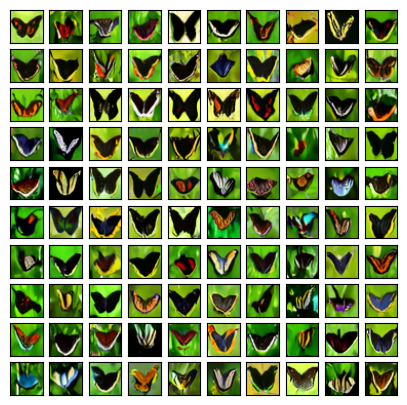

In [10]:
run_inference(
    unet,
    emb,
    class_name="butterfly",
    class_list=classes,
    s=3.0,
)

#### $s=0.1$

100%|████████████████████████████████████████████████████████████| 1000/1000 [08:33<00:00,  1.95it/s]


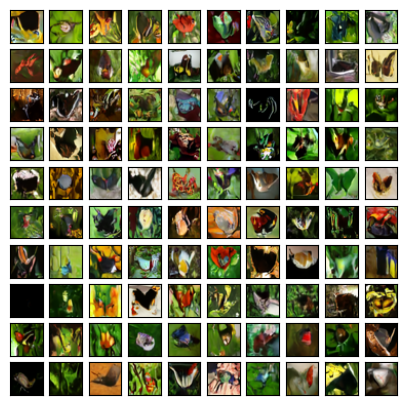

In [11]:
run_inference(
    unet,
    emb,
    class_name="butterfly",
    class_list=classes,
    s=0.1,
)